# Description

Bank "Beta" has a problem. Each month clients leave the bank. The goal for this project is to build a model, which will predict which clients are likely to leave next. F1-metric must be at least 0.59.

# Plan

- Libraries
- Load Data
- Prepare Data
- Build Model
- Build Model With Balanced Data
- Find the Best Model
- Final Test
- Reflection 

# Libraries

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Because the target feature is quantitive we will be using classifiers
# DecisionTreeClassifier / RandomForestClassifier / LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.utils import shuffle

# Load Data

In [61]:
local_path = './datasets/Churn.csv'
web_path = '/datasets/Churn.csv'

if os.path.exists(local_path):
  df = pd.read_csv(local_path)
elif os.path.exists(web_path):
  df = pd.read_csv(web_path)

In [62]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB
None


Looks like table 'Tenure' has missing values. Reminder, this table shows number of years a preson has been a client, probably if there is a missing value, a client has been with the bank for less than a year, so we can fill those values as 0.

In [63]:
df['Tenure'] = df['Tenure'].fillna(0)

# Prepare Data

### Sanity check

In [64]:
print('poisitive target ratio', df['Exited'].sum() / df['Exited'].size)

poisitive target ratio 0.2037


We might try increasing positive selection, or decreaseing negative selection.

### Inspect all non-numeric columns, drop the useless and encode the required.

In [65]:
print(df['Surname'].head())

0    Hargrave
1        Hill
2        Onio
3        Boni
4    Mitchell
Name: Surname, dtype: object


We will nod need last name of the customer to train our model

In [66]:
df = df.drop(['Surname'], axis=1)

In [67]:
print(df['Geography'].head())

0    France
1     Spain
2    France
3    France
4     Spain
Name: Geography, dtype: object


This column will be relative to the model.

In [68]:
print(pd.get_dummies(df['Geography']).head())

   France  Germany  Spain
0       1        0      0
1       0        0      1
2       1        0      0
3       1        0      0
4       0        0      1


Since there are only three states, we can use drop_first=True. But first, lets inspect the rest of the columns.

In [69]:
print(pd.get_dummies(df['Gender'].head()))

   Female
0       1
1       1
2       1
3       1
4       1


Ok, everything is ready for OHE (one hot encoding)

In [70]:
df = pd.get_dummies(df, drop_first=True)

In [71]:
df.head()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,1,15634602,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,2,15647311,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,3,15619304,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,4,15701354,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,5,15737888,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


### Seperate into train, validation, test data!

In [72]:
features = df.drop(['Exited'], axis=1)
target = df['Exited']

print(features.shape)
print(target.shape)

(10000, 13)
(10000,)


In [73]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=12345)
features_train, features_valid, target_train, target_valid = train_test_split(features_train, target_train, test_size=0.25, random_state=12345)

print('Train')
print(features_train.shape, target_train.shape)
print('Validation')
print(features_valid.shape, target_valid.shape)
print('Test')
print(features_test.shape, target_test.shape)

Train
(6000, 13) (6000,)
Validation
(2000, 13) (2000,)
Test
(2000, 13) (2000,)


# Build Model

In [74]:
def draw_roc_curve(model, features_valid, target_valid):
  proba_valid = model.predict_proba(features_valid)
  proba_one_valid = proba_valid[:, 1]
  fpr, tpr, thresholds = roc_curve(target_valid, proba_one_valid)
  plt.plot(fpr, tpr)
  plt.plot([0,1], [0, 1], linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title("ROC-кривая")
  plt.show()
  print("AUC_ROC", roc_auc_score(target_valid, proba_one_valid))

In [75]:
model = DecisionTreeClassifier(random_state=12345)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print('DecisionTreeClassifier random_state=12345')
print('F1', f1_score(target_valid, predicted_valid))

DecisionTreeClassifier random_state=12345
F1 0.4671532846715329


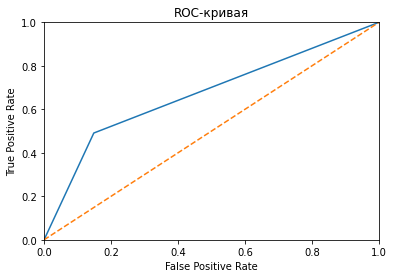

AUC_ROC 0.671254563921929


In [76]:
draw_roc_curve(model, features_valid, target_valid)

So far F1 score is not high enough.


# Build Model With Balanced Data

### Class weight

In [77]:
model = DecisionTreeClassifier(class_weight='balanced', random_state=12345)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print('DecisionTreeClassifier random_state=12345')
print('F1', f1_score(target_valid, predicted_valid))

DecisionTreeClassifier random_state=12345
F1 0.48040455120101133


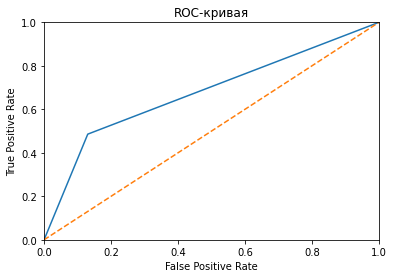

AUC_ROC 0.6777088277416513


In [78]:
draw_roc_curve(model, features_valid, target_valid)

F1 score improved a little bit.

### Upsampling and downsampling

In [79]:
def upsample(features, target, repeat):
  features_zeros = features[target == 0]
  features_ones = features[target == 1]
  target_zeros = target[target == 0]
  target_ones = target[target == 1]

  features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
  target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
  features_upsampled, target_upsampled = shuffle(
      features_upsampled, target_upsampled, random_state=12345)
    
  return features_upsampled, target_upsampled

In [80]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 2)

In [81]:
model = DecisionTreeClassifier(class_weight='balanced', random_state=12345)
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
print('DecisionTreeClassifier random_state=12345')
print('F1', f1_score(target_valid, predicted_valid))

DecisionTreeClassifier random_state=12345
F1 0.48805031446540875


Upsampling worked, lets try large upsampling different values in a loop

In [82]:
for repeat in range(2,10):
  features_upsampled, target_upsampled = upsample(features_train, target_train, repeat)
  model = DecisionTreeClassifier(class_weight='balanced', random_state=12345)
  model.fit(features_upsampled, target_upsampled)
  predicted_valid = model.predict(features_valid)
  print('DecisionTreeClassifier repeat', repeat)
  print('F1', f1_score(target_valid, predicted_valid))

DecisionTreeClassifier repeat 2
F1 0.48805031446540875
DecisionTreeClassifier repeat 3
F1 0.5
DecisionTreeClassifier repeat 4
F1 0.4892268694550063
DecisionTreeClassifier repeat 5
F1 0.4949748743718594
DecisionTreeClassifier repeat 6
F1 0.5006257822277848
DecisionTreeClassifier repeat 7
F1 0.4962216624685139
DecisionTreeClassifier repeat 8
F1 0.5068664169787765
DecisionTreeClassifier repeat 9
F1 0.49420849420849416


For upsampling the best number of repeats is 8, now lets try downsampling in a loop.

In [83]:
def downsample(features, target, fraction):
  features_zeros = features[target == 0]
  features_ones = features[target == 1]
  target_zeros = target[target == 0]
  target_ones = target[target == 1]

  features_downsampled = pd.concat(
      [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
  target_downsampled = pd.concat(
      [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
  
  features_downsampled, target_downsampled = shuffle(
      features_downsampled, target_downsampled, random_state=12345)
  
  return features_downsampled, target_downsampled

In [84]:
for fraction in np.arange(0.9, 0.1, -0.1):
  features_downsampled, target_downsampled = downsample(features_train, target_train, fraction)
  model = DecisionTreeClassifier(class_weight='balanced', random_state=12345)
  model.fit(features_downsampled, target_downsampled)
  predicted_valid = model.predict(features_valid)
  print('DecisionTreeClassifier fraction', fraction)
  print('F1', f1_score(target_valid, predicted_valid))

DecisionTreeClassifier fraction 0.9
F1 0.4589774078478002
DecisionTreeClassifier fraction 0.8
F1 0.4651711924439198
DecisionTreeClassifier fraction 0.7000000000000001
F1 0.4761904761904762
DecisionTreeClassifier fraction 0.6000000000000001
F1 0.45890410958904115
DecisionTreeClassifier fraction 0.5000000000000001
F1 0.47558386411889597
DecisionTreeClassifier fraction 0.40000000000000013
F1 0.4590163934426229
DecisionTreeClassifier fraction 0.30000000000000016
F1 0.4555160142348755
DecisionTreeClassifier fraction 0.20000000000000018
F1 0.4487179487179487


Looks like downsampling isn't working, so we will stick with the upsampling by the magnitude of 8

In [85]:
features_train, target_train = upsample(features_train, target_train, 8)
# testing once again
model = DecisionTreeClassifier(class_weight='balanced', random_state=12345)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print("DecisionTreeClassifier class_weight='balanced' random_state=12345")
print('F1', f1_score(target_valid, predicted_valid))

DecisionTreeClassifier class_weight='balanced' random_state=12345
F1 0.5068664169787765


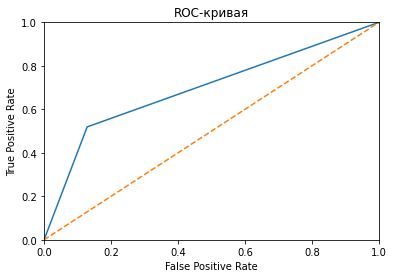

AUC_ROC 0.6952651247220321


In [86]:
draw_roc_curve(model, features_valid, target_valid)

# Find the Best Model

### Bring the big guns, we will start with the random forest classifier

In [87]:
for depth in range(1, 16):
  model = RandomForestClassifier(n_estimators=20, max_depth=depth, random_state=12345)
  model.fit(features_train, target_train)
  predicted_valid = model.predict(features_valid)
  print(depth, 'F1', f1_score(target_valid, predicted_valid))
  

1 F1 0.32705980761187786
2 F1 0.35975892443208163
3 F1 0.3913267940113578
4 F1 0.42358328563251285
5 F1 0.44740024183796867
6 F1 0.4640000000000001
7 F1 0.49350649350649345
8 F1 0.508108108108108
9 F1 0.5177832919768404
10 F1 0.5425246195165623
11 F1 0.5403846153846154
12 F1 0.5637860082304527
13 F1 0.5480984340044743
14 F1 0.5633136094674557
15 F1 0.5484276729559749


Best depth for the RandomForestClassifer is 12

In [88]:
for estimators in range(10, 110, 10):
  model = RandomForestClassifier(n_estimators=estimators, max_depth=12, random_state=12345)
  model.fit(features_train, target_train)
  predicted_valid = model.predict(features_valid)
  print(estimators, 'F1', f1_score(target_valid, predicted_valid))

10 F1 0.5624344176285414
20 F1 0.5637860082304527
30 F1 0.5693430656934307
40 F1 0.5705263157894738
50 F1 0.5693121693121693
60 F1 0.5666316894018888
70 F1 0.5644820295983087
80 F1 0.5641569459172853
90 F1 0.5690200210748155
100 F1 0.5675105485232067


The best F1-score is 0.57 which is still not enough, but let's take a look at the roc curve

In [89]:
model = RandomForestClassifier(n_estimators=40, max_depth=12, random_state=12345)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print(40, 'F1', f1_score(target_valid, predicted_valid))

40 F1 0.5705263157894738


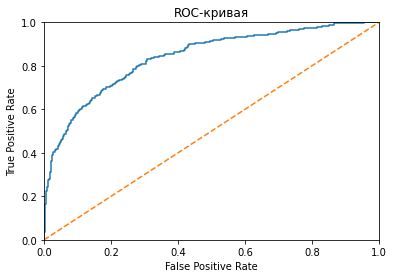

AUC_ROC 0.8397552768236215


In [90]:
draw_roc_curve(model, features_valid, target_valid)

We can see that 0.57 is not enough, but the score could be better on the test selection.

# Final Test

In [91]:
model = RandomForestClassifier(n_estimators=40, max_depth=12, random_state=12345)
model.fit(features_train, target_train)
predicted_test = model.predict(features_test)
print('F1', f1_score(target_test, predicted_test))

F1 0.6088669950738915


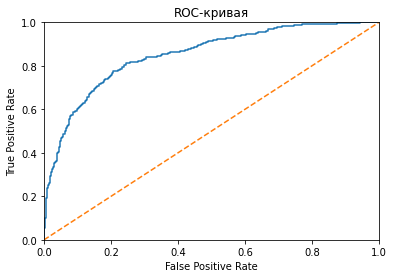

AUC_ROC 0.8506828491925362


In [92]:
draw_roc_curve(model, features_test, target_test)

# Reflection

- We loaded the data
- Dropped the column with the last names
- Filled values of the 'Tenure' with 0
- Seperated data into training, validation, testing data
- Builded DecisionTreeClassifier and tested F1 score
- We balanced the data
- We tried upsampling and downsampling, but upsampling worked better
- We trained RandomForestClassifier with different hyperparameters
- We got our model to the 0.609 F1 score
- Yay, Greate sucess!!!